In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

## Homework #3

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name: Runze Li  
NetID: rl50xx  
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
np.random.seed(5)

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Important Note**: *All solutions to the problems below must use the approaches taught so far in the course for answering the questions. There are other approaches for solving these problems that do not require the use of Bayesian approaches, PyMC, quadratic approximation, etc. However, we will soon encounter problems where those tools lack the functionality that is needed to solve the problems. It will be to your benefit to practice using the approach shown in lecture and found in the textbook to begin practicing for what is to come later. In addition, you will not receive full credit on your answers if you do not use the techniques being taught in the course.*

**Question 1 (6 points)**. For each of the four DAGs below, state which variables (**if any**) you must adjust for/condition on/stratify by (all of these terms are equivalent) to estimate the total causal influence of X on Y.

Be sure to **provide justification** for your response to each part based on identification of elementary confounds and using the backdoor criterion. **Limit your responses to each part to no more than 2 sentences.** 

![](dags.png)

*Note: Feel free to use https://dagitty.net/dags.html to confirm your adjustment set but understand that you will not receive full credit without justifying your responses.* 

_Type your answer here, replacing this text._

__Answer:__   
A) We need to adjust for Z to estimate the total causal influence of X on Y, because there is a backdoor path from Z to X.   
B) We don't need to adjust for any variable, because there is no backdoor path to X.  
C) We don't need to adjust for any variable, because there is no path to Y.   
D) We need to adjust for A to estimate the total causal influence of X on Y, because there is a backdoor path from A to X.

A)

B)

C)

D)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2 (17 points)**. The data `foxes.csv` are 116 foxes from 30 different urban groups in England. These fox groups are like street gangs. Group size (`groupsize`) varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more average food (`avgfood`) than others. And food influences the weight of each fox. 

Assume the causal model defined by this DAG:  

![](fox_dag.png)

where $F$ is `avgfood`, $G$ is `groupsize`, $A$ is `area`, and $W$ is `weight`.  

Solve the following problems based on the above data and causal model:

1. Considering area ($A$) as the treatment and average food ($F$) as the outcome, use the backdoor criterion to determine the variables that should be included in your model. 

    *Note: Be sure to explicitly state how the backdoor criterion was applied and the implications for the definition of your statistical model due to your use of the backdoor criterion.*

_Type your answer here, replacing this text._

__Answer:__    
A and F should be included in the model because there is a backdoor path to A. We only need to include exposure(A) and outcome(F) in the model.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

2. Estimate the **total causal effect** of $A$ on $F$.  **Include a prior predictive simulation** to justify your assignment of prior distributions to unobserved intercept and slope parameters in your model. **Limit your justification to no more than 3 sentences.**
    
    *Note:* 
    *   Perform your prior predictive simulation without using the `pymc.sample_prior_predictive()` function. 
    *   Feel free to assign an Exponential(1) to your standard deviation parameter in your model without justifying this choice.
    * You might want to consider standardizing the variables in your model (but this is not a requirement).

_Type your answer here, replacing this text._

Text(0, 0.5, 'avgfood')

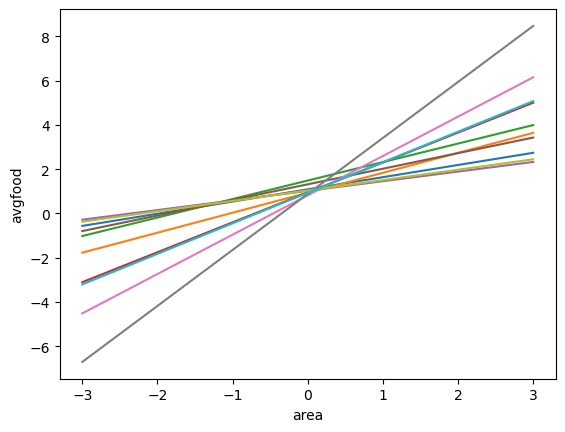

In [4]:
# Write code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

d = pd.read_csv("Data/foxes.csv")
A = d.area
F = d.avgfood
A_std = standardize(A)
F_std = standardize(F)

n = 10
alpha = stats.norm.rvs(1, 0.2, size=n)
beta = stats.lognorm.rvs(s=0.5, loc=0, size=n)
# Abar = 3.0
Aseq = np.linspace(-3, 3, 60)
for i in range(n):
    plt.plot(Aseq, alpha[i] + beta[i] * Aseq)
plt.xlabel("area")
plt.ylabel("avgfood")

According to the plot, we set the prior distribution:

- alpha = Normal(0, 0.2)
- beta = LogNormal(0, 0.5)
- sigma = Uniform(0, 10)
- mu = alpha+beta*area\_seq
- W = Normal(mu, sigma)

In [5]:
import pymc as pm
from quap import quap

with pm.Model() as model_AF:
    a = pm.Normal('a', 1, 0.2)
    b = pm.Lognormal('b', 0, 0.5)
    mu = pm.Deterministic("mu", a + b * A_std)
    sigma = pm.Uniform("sigma", 0, 10)
    weight = pm.Normal("weight", mu, sigma, observed=F_std)
    idata, posterior = quap([a, b, sigma], n_samples=1000)

az.summary(idata, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.045,0.044,-0.024,0.113
b,0.883,0.048,0.810,0.963
sigma,0.467,0.070,0.365,0.581


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'avgfood')

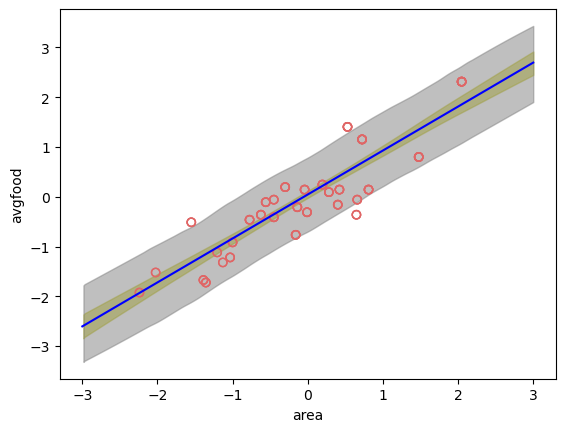

In [6]:
area_seq = np.linspace(-3, 3, 60)
idata_thinned = az.extract(idata, num_samples=1000)

mu_pred = np.zeros((len(area_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values
sigma_values = idata_thinned.sigma.values

weight_pred = np.zeros((len(area_seq), idata_thinned.sizes["sample"]))

for i, area in enumerate(area_seq):
    mu_pred[i] = a_values + b_values * area
    weight_pred[i] = stats.norm.rvs(mu_pred[i], sigma_values)

mu_mean = mu_pred.mean(1)

ax = az.plot_hdi(area_seq, mu_pred.T, color='y')
az.plot_hdi(area_seq, weight_pred.T, ax=ax, color="gray")
plt.scatter(A_std, F_std, facecolors='none', edgecolors="#e06666")
plt.plot(area_seq, mu_mean, color='b')
plt.xlabel("area")
plt.ylabel("avgfood")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Answer the following question based on the results of your model:** 

What effect would increasing the area of a territory have on the amount of food inside it? **Limit your answer to no more than 2 sentences.**

_Type your answer here, replacing this text._

__Answer:__   
According to the plot, we can find that the area of the territory is positively associated with the amount of food, and the effect can be indicated by the upward slope of the regression line.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3 (17 points)**. In this question, you will estimate **the total and direct causal effects** of adding food ($F$) to a territory on the weight ($W$) of foxes. 

Which model variables do you need to adjust for in each case? 

**Make sure to explicitly state the adjustment sets needed for properly estimating the effects.** *Hint: The backdoor criterion only includes variables in the adjustment set that need to be included in the model to close backdoors into your treatment variable. Variables may need to be included in your adjustment set to properly estimate a causal effect even when the variable is not part of a backdoor path.*

_Type your answer here, replacing this text._

__Answer:__   
We don't need to adjust for any variable in the adjustment sets of total causal effects, because there is no backdoor path.   
We adjust for G in the adjustment sets of direct causal effects, because G is a mediator.

Estimate **the total causal effect** of adding food ($F$) to a territory on the weight ($W$) of foxes. Communicate this effect using a summary table or visualization/plot of the posterior estimate.

In [7]:
# Write code here
d = pd.read_csv("Data/foxes.csv")
F = d.avgfood
G = d.groupsize
W = d.weight

F_std = standardize(F)
G_std = standardize(G)
W_std = standardize(W)

with pm.Model() as m_FW:
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    mu = pm.Deterministic("mu", a + b*F_std)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu, sigma, observed=W_std)
    idata_FW, posterior_FW = quap([a, b, sigma])

az.summary(idata_FW, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.001,0.091,-0.154,0.136
b,-0.025,0.092,-0.166,0.127
sigma,0.992,0.066,0.887,1.099


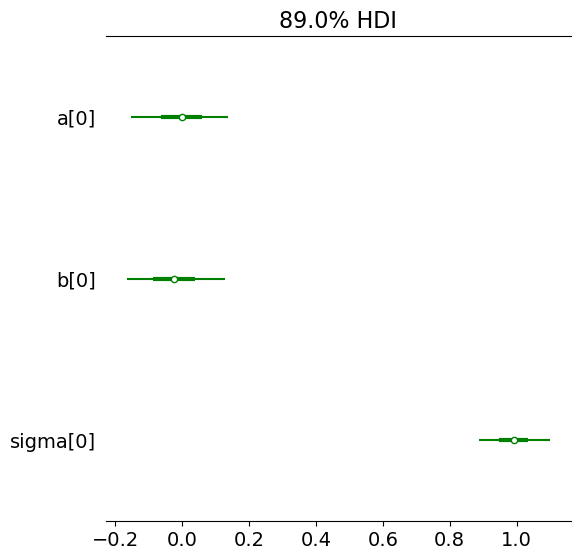

In [8]:
_ = az.plot_forest(idata_FW, colors='g')

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'weight')

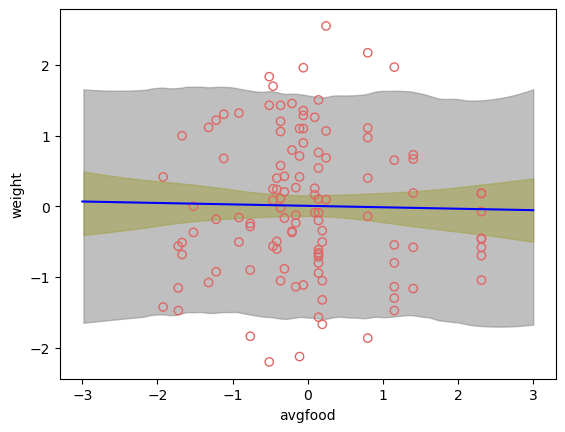

In [9]:
avgfood_seq = np.linspace(-3, 3, 60)
idata_thinned = az.extract(idata_FW, num_samples=1000)

mu_pred = np.zeros((len(avgfood_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values
sigma_values = idata_thinned.sigma.values

weight_pred = np.zeros((len(avgfood_seq), idata_thinned.sizes["sample"]))

for i, avgfood in enumerate(avgfood_seq):
    mu_pred[i] = a_values + b_values * avgfood
    weight_pred[i] = stats.norm.rvs(mu_pred[i], sigma_values)

mu_mean = mu_pred.mean(1)

ax = az.plot_hdi(avgfood_seq, mu_pred.T, color='y')
az.plot_hdi(avgfood_seq, weight_pred.T, ax=ax, color="gray")
plt.scatter(F_std, W_std, facecolors='none', edgecolors="#e06666")
plt.plot(avgfood_seq, mu_mean, color='b')
plt.xlabel("avgfood")
plt.ylabel("weight")

Estimate **the direct causal effect** of adding food ($F$) to a territory on the weight ($W$) of foxes. Communicate this effect using a summary table or visualization/plot of the posterior estimate.

In [10]:
# Write code here
with pm.Model() as m_FGW:
    a = pm.Normal("a", 0, 10)
    b_FW = pm.Normal("b_FW", 0, 10)
    b_GW = pm.Normal("b_GW", 0, 10)
    mu = pm.Deterministic("mu", a + b_FW*F_std + b_GW*G_std)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu, sigma, observed=W_std)
    idata_FGW, posterior_FGW = quap([a, b_FW, b_GW, sigma])

az.summary(idata_FGW, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.000,0.087,-0.137,0.139
b_FW,0.640,0.201,0.325,0.962
b_GW,-0.736,0.202,-1.056,-0.416
sigma,0.938,0.066,0.831,1.041


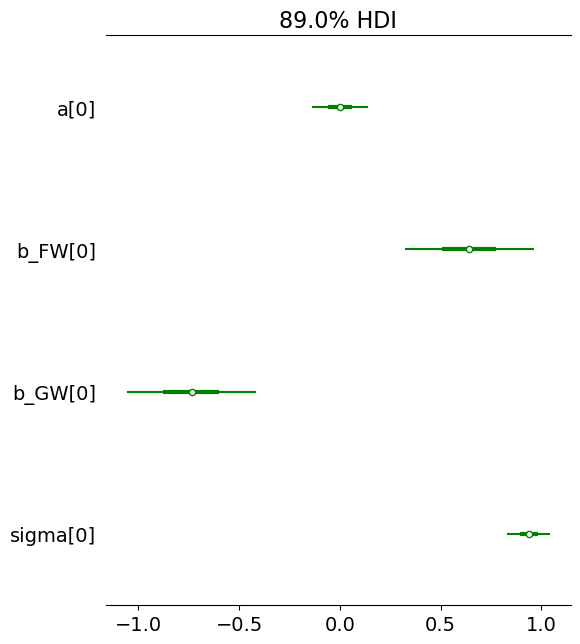

In [11]:
_ = az.plot_forest(idata_FGW, colors='g')

According to the chart, we can find that avgfood is positively correlated with weight, and groupsize is negatively correlated with weight.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4 (10 points)**. To estimate the the causal effect of group size ($G$) on weight ($W$), which variables do you need to adjust for? **Explicitly state the adjustment set needed for properly estimating the effect.**

_Type your answer here, replacing this text._

__Answer:__      
We adjust for F in the adjustment sets of direct causal effects, because F is a confounder.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Estimate the causal effect of group size (G) on weight (W). Express this effect using a summary table or plot/visualization of the posterior estimate.

_Type your answer here, replacing this text._

In [12]:
# Write code here
with pm.Model() as m_GW:
    a = pm.Normal("a", 0, 10)
    b_GW = pm.Normal("b_GW", 0, 10)
    b_FW = pm.Normal("b_FW", 0, 10)

    # ... 
    mu = pm.Deterministic("mu", a + b_GW*G_std + b_FW*F_std)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu, sigma, observed=W_std)
    idata_GW, posterior_GW = quap([a, b_GW, b_FW, sigma])

az.summary(idata_GW, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.000,0.087,-0.136,0.143
b_GW,-0.736,0.202,-1.049,-0.404
b_FW,0.639,0.203,0.319,0.964
sigma,0.939,0.065,0.838,1.046


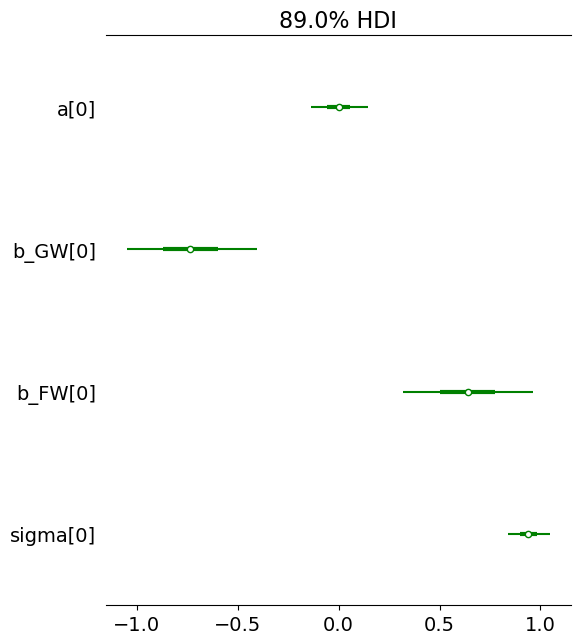

In [13]:
_ = az.plot_forest(idata_GW, colors='g')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

In light of your estimates from Questions 2 - 4, what do you think is going on with these foxes? Feel free to speculate — **all that matters is that you justify your speculation.**

_Type your answer here, replacing this text._

__Answer:__   
According to the charts from Questions 2 to 4, we can find:   
- As the area increases, the average food will increase.
- For the total causal effect from F to W, the average food has little impact on the weight of each fox.
- For the direct causal effect, the average food is positively correlated with the weight of each fox, and the group size of fox groups is negatively correlated with the weight.   

In [14]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [15]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True, files=['dags.png', 'fox_dag.png'])

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q4.3 results: All test cases passed!
